## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [325]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [326]:
df = pd.read_csv('data/CO2 Emissions_Canada.csv')

#### Show Top 5 Records

In [327]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [328]:
df.shape

(7385, 12)

In [329]:
df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [330]:
df.dtypes

Make                                 object
Model                                object
Vehicle Class                        object
Engine Size(L)                      float64
Cylinders                             int64
Transmission                         object
Fuel Type                            object
Fuel Consumption City (L/100 km)    float64
Fuel Consumption Hwy (L/100 km)     float64
Fuel Consumption Comb (L/100 km)    float64
Fuel Consumption Comb (mpg)           int64
CO2 Emissions(g/km)                   int64
dtype: object

We treat the *Cylinders* variable as categorical to avoid imposing a linear and uniform effect of each additional cylinder on CO₂ emissions, allowing the model to learn potentially non-linear and non-monotonic differences directly from the data.


In [331]:
df['Cylinders']=df['Cylinders'].astype('object')

City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km). The combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per gallon (mpg). For consistency and to avoid redundancy, only the combined fuel consumption in L/100 km is retained for analysis and modeling.

In [332]:
df = df.drop(columns=['Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (mpg)'], axis=1)

In [333]:
print("Categories in 'Make' variable:     ",end=" " )
print(df['Make'].unique())

print("Categories in 'Model' variable:  ",end=" ")
print(df['Model'].unique())

print("Categories in'Vehicle Class' variable:",end=" " )
print(df['Vehicle Class'].unique())

print("Categories in 'Cylinders' variable:     ",end=" " )
print(df['Cylinders'].unique())

print("Categories in 'Transmission' variable:     ",end=" " )
print(df['Transmission'].unique())

print("Categories in 'Fuel Type' variable:     ",end=" " )
print(df['Fuel Type'].unique())

Categories in 'Make' variable:      ['ACURA' 'ALFA ROMEO' 'ASTON MARTIN' 'AUDI' 'BENTLEY' 'BMW' 'BUICK'
 'CADILLAC' 'CHEVROLET' 'CHRYSLER' 'DODGE' 'FIAT' 'FORD' 'GMC' 'HONDA'
 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA' 'LAMBORGHINI' 'LAND ROVER'
 'LEXUS' 'LINCOLN' 'MASERATI' 'MAZDA' 'MERCEDES-BENZ' 'MINI' 'MITSUBISHI'
 'NISSAN' 'PORSCHE' 'RAM' 'ROLLS-ROYCE' 'SCION' 'SMART' 'SRT' 'SUBARU'
 'TOYOTA' 'VOLKSWAGEN' 'VOLVO' 'GENESIS' 'BUGATTI']
Categories in 'Model' variable:   ['ILX' 'ILX HYBRID' 'MDX 4WD' ... 'Tacoma 4WD D-Cab TRD Off-Road/Pro'
 'Atlas Cross Sport 4MOTION' 'XC40 T4 AWD']
Categories in'Vehicle Class' variable: ['COMPACT' 'SUV - SMALL' 'MID-SIZE' 'TWO-SEATER' 'MINICOMPACT'
 'SUBCOMPACT' 'FULL-SIZE' 'STATION WAGON - SMALL' 'SUV - STANDARD'
 'VAN - CARGO' 'VAN - PASSENGER' 'PICKUP TRUCK - STANDARD' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'STATION WAGON - MID-SIZE'
 'PICKUP TRUCK - SMALL']
Categories in 'Cylinders' variable:      [4 6 12 8 10 3 5 16]
Categories in 'Transmission' v

### Feature Engineering: Handling High Cardinality in 'Make' Variable

Based on the **Exploratory Data Analysis (EDA)**, the `Make` feature contains 42 distinct categories. 
To improve model robustness and prevent overfitting on infrequent brands, I have selected the **Top 10 Manufacturers** based on their frequency in the dataset. 

All other manufacturers will be grouped into a single category labeled `'Others'`. 
This approach ensures:
1. **Schema Consistency:** The model expects a fixed set of features during inference.
2. **Noise Reduction:** Infrequent categories with insufficient data points are generalized.
3. **Reproducibility:** By hard-coding the top brands, we ensure the preprocessing logic remains stable across different environments.

In [334]:
TOP_MAKES = ['FORD', 'CHEVROLET', 'BMW', 'MERCEDES-BENZ', 'PORSCHE', 
             'TOYOTA', 'GMC', 'AUDI', 'NISSAN', 'JEEP']

df['Make'] = df['Make'].str.upper() 

df['Make'] = df['Make'].where(df['Make'].isin(TOP_MAKES), 'Others')

print("Categories in 'Make' variable:     ",end=" " )
print(df['Make'].unique())

Categories in 'Make' variable:      ['Others' 'AUDI' 'BMW' 'CHEVROLET' 'FORD' 'GMC' 'JEEP' 'MERCEDES-BENZ'
 'NISSAN' 'PORSCHE' 'TOYOTA']


### Feature Extraction from 'Model' Variable

Analysis of the **Word Cloud** for the `Model` feature in FDA phase revealed that certain technical terms like **'FFV', 'AWD', '4WD',** and **'4X4'** are highly frequent. These terms represent specific vehicle technologies that significantly impact fuel consumption and $CO_2$ emissions. 

To reduce the high cardinality of the `Model` feature (over 2000 distinct values), I have implemented a keyword-based extraction strategy. Models containing these keywords are categorized accordingly, while all others are grouped into `'Other_Models'`.

#### Technical Definitions:
* **FFV (Flexible-Fuel Vehicle):** Vehicles designed to run on more than one type of fuel, typically gasoline blended with ethanol (up to 85%). Ethanol content alters the emission profile compared to pure gasoline.
* **AWD (All-Wheel Drive):** A drivetrain system that automatically directs power to all four wheels. The added mechanical complexity and weight usually lead to higher fuel consumption.
* **4WD / 4X4 (Four-Wheel Drive):** Similar to AWD but typically designed for off-road conditions with manual or part-time engagement. These systems often correlate with larger engine sizes and higher emission levels.

In [ ]:
keywords = ['FFV', 'AWD', '4WD', '4X4']

df['Model'] = df['Model'].apply(
    lambda x: next((word for word in keywords if word in str(x).upper()), 'Other_Models')
)

print(df['Model'].value_counts())

Model
Other_Models    5059
AWD             1080
FFV              592
4WD              397
4X4              257
Name: count, dtype: int64


In [336]:
keywords_vehicle = ['SUV - SMALL', 'MID-SIZE', 'COMPACT', 'SUV - STANDARD', 'FULL-SIZE', 'SUBCOMPACT', 'PICKUP TRUCK - STANDARD', 'TWO-SEATER', 'MINICOMPACT', 'STATION WAGON - SMALL']

df['Vehicle Class'] = df['Vehicle Class'].str.upper() 

df['Vehicle Class'] = df['Vehicle Class'].where(df['Vehicle Class'].isin(keywords_vehicle), 'Others')

print("Categories in 'Vehicle Class' variable:     ",end=" " )
print(df['Vehicle Class'].unique())
print(df['Vehicle Class'].value_counts())

Categories in 'Vehicle Class' variable:      ['COMPACT' 'SUV - SMALL' 'MID-SIZE' 'TWO-SEATER' 'MINICOMPACT'
 'SUBCOMPACT' 'FULL-SIZE' 'STATION WAGON - SMALL' 'SUV - STANDARD'
 'Others' 'PICKUP TRUCK - STANDARD']
Vehicle Class
SUV - SMALL                1217
MID-SIZE                   1133
COMPACT                    1022
SUV - STANDARD              735
FULL-SIZE                   639
SUBCOMPACT                  606
PICKUP TRUCK - STANDARD     538
TWO-SEATER                  460
Others                      457
MINICOMPACT                 326
STATION WAGON - SMALL       252
Name: count, dtype: int64


### Transmission Feature Engineering: Splitting Type and Gears

The original `Transmission` variable is a composite feature containing both the **gearbox technology** and the **number of gears**. To help the model better capture these distinct physical properties, I have split this feature into two separate variables:

1. **Trans_Type (Categorical):** Extracts the transmission technology (e.g., AS = Automatic with select shift, M = Manual, AV = Continuously variable). This reflects the efficiency and shifting logic of the vehicle.
2. **Gears (Numerical):** Extracts the number of gear ratios (3-10). More gears generally allow the engine to run at more efficient RPM ranges, directly impacting $CO_2$ emissions.

This transformation prevents the model from treating 'AS6' and 'AS10' as completely unrelated categories, allowing it to recognize they share the same 'AS' technology but differ in gear count.

In [337]:
def split_transmission(trans):
    """
    Separates the transmission technology type from the number of gears.
    Example: 'AS10' -> ('AS', 10)
    """
    # Handle missing values or previously grouped 'Others' categories
    if trans == 'Others' or pd.isna(trans):
        return 'Others', 0
    
    # Extract alphabetical characters (Transmission Type) using Regular Expressions
    letters = re.findall(r'[A-Za-z]+', trans)
    
    # Extract numerical digits (Number of Gears) using Regular Expressions
    numbers = re.findall(r'\d+', trans)
    
    # Assign the first match for type; default to 'Unknown' if no letters found
    trans_type = letters[0] if letters else 'Unknown'
    
    # Assign the first match for gears and convert to integer; default to 0 (e.g., for CVT/AV)
    gears = int(numbers[0]) if numbers else 0
    
    return trans_type, gears

# Apply the function and create two distinct features: 'Trans_Type' and 'Gears'
# pd.Series is used to map the function's tuple output into two separate columns
df[['Trans_Type', 'Gears']] = df['Transmission'].apply(lambda x: pd.Series(split_transmission(x)))

# Drop the original 'Transmission' column to reduce redundancy and simplify the feature set
df.drop('Transmission', axis=1, inplace=True)

# Verify the transformation by displaying the frequency of the new engineered features
print(df[['Trans_Type']].value_counts())
print(df[['Gears']].value_counts())

Trans_Type
AS            3127
A             1851
M             1185
AM             646
AV             576
Name: count, dtype: int64
Gears
6        3259
8        1802
7        1026
9         419
5         307
0         295
10        210
4          67
Name: count, dtype: int64


In [338]:
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Trans_Type,Gears
0,Others,Other_Models,COMPACT,2.0,4,Z,8.5,196,AS,5
1,Others,Other_Models,COMPACT,2.4,4,Z,9.6,221,M,6
2,Others,Other_Models,COMPACT,1.5,4,Z,5.9,136,AV,7
3,Others,4WD,SUV - SMALL,3.5,6,Z,11.1,255,AS,6
4,Others,AWD,SUV - SMALL,3.5,6,Z,10.6,244,AS,6


In [339]:
df.dtypes

Make                                 object
Model                                object
Vehicle Class                        object
Engine Size(L)                      float64
Cylinders                            object
Fuel Type                            object
Fuel Consumption Comb (L/100 km)    float64
CO2 Emissions(g/km)                   int64
Trans_Type                           object
Gears                                 int64
dtype: object

### Decision on 'Gears' Feature: Numerical vs. Categorical

I have decided to treat the **'Gears'** feature as a **Numerical** variable rather than categorical for the following reasons:
1. **Mathematical Significance:** Gear counts have an inherent order. A higher number of gears often correlates with better fuel efficiency and lower emissions due to optimized engine RPM ranges.
2. **Dimensionality Control:** Treating gears as numerical keeps the information in a single column, preventing the unnecessary expansion of the feature space that would occur with One-Hot Encoding.
3. **Model Interpretability:** Numerical representation allows the model to capture the linear or non-linear trends associated with gear ratios.

In [340]:
print("Categories in 'Make' variable:     ",end=" " )
print(df['Make'].unique())

print("Categories in 'Model' variable:     ",end=" " )
print(df['Model'].unique())

print("Categories in 'MVehicle Classake' variable:     ",end=" " )
print(df['Vehicle Class'].unique())

print("Categories in 'Cylinders' variable:     ",end=" " )
print(df['Cylinders'].unique())

print("Categories in 'Trans_Type' variable:     ",end=" " )
print(df['Trans_Type'].unique())

print("Categories in 'Fuel Type' variable:     ",end=" " )
print(df['Fuel Type'].unique())

Categories in 'Make' variable:      ['Others' 'AUDI' 'BMW' 'CHEVROLET' 'FORD' 'GMC' 'JEEP' 'MERCEDES-BENZ'
 'NISSAN' 'PORSCHE' 'TOYOTA']
Categories in 'Model' variable:      ['Other_Models' '4WD' 'AWD' 'FFV' '4X4']
Categories in 'MVehicle Classake' variable:      ['COMPACT' 'SUV - SMALL' 'MID-SIZE' 'TWO-SEATER' 'MINICOMPACT'
 'SUBCOMPACT' 'FULL-SIZE' 'STATION WAGON - SMALL' 'SUV - STANDARD'
 'Others' 'PICKUP TRUCK - STANDARD']
Categories in 'Cylinders' variable:      [4 6 12 8 10 3 5 16]
Categories in 'Trans_Type' variable:      ['AS' 'M' 'AV' 'AM' 'A']
Categories in 'Fuel Type' variable:      ['Z' 'D' 'X' 'E' 'N']


In [342]:
X = df.drop(columns=['CO2 Emissions(g/km)'],axis=1)
y = df['CO2 Emissions(g/km)']
X.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Fuel Type,Fuel Consumption Comb (L/100 km),Trans_Type,Gears
0,Others,Other_Models,COMPACT,2.0,4,Z,8.5,AS,5
1,Others,Other_Models,COMPACT,2.4,4,Z,9.6,M,6
2,Others,Other_Models,COMPACT,1.5,4,Z,5.9,AV,7
3,Others,4WD,SUV - SMALL,3.5,6,Z,11.1,AS,6
4,Others,AWD,SUV - SMALL,3.5,6,Z,10.6,AS,6


In [343]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [344]:
X = preprocessor.fit_transform(X)

In [345]:
X.shape

(7385, 48)

### Final Feature Set Validation

After comprehensive Feature Engineering and Preprocessing, the input matrix $X$ has reached a final shape of **(7385, 48)**. 

`StandardScaler` is applied to numerical inputs and `OneHotEncoder` to categorical inputs via a `ColumnTransformer` pipeline.

The model is now ready for training with a balanced feature-to-sample ratio, minimizing the risk of overfitting.

In [362]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
X_train.shape, X_test.shape

((5908, 48), (1477, 48))

#### Create an Evaluate Function to give all metrics after model Training

In [355]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [363]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 4.9480
- Mean Absolute Error: 2.9398
- R2 Score: 0.9928
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.8508
- Mean Absolute Error: 3.2160
- R2 Score: 0.9903


Lasso
Model performance for Training set
- Root Mean Squared Error: 9.3488
- Mean Absolute Error: 6.2108
- R2 Score: 0.9743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 9.9986
- Mean Absolute Error: 6.4979
- R2 Score: 0.9717


Ridge
Model performance for Training set
- Root Mean Squared Error: 4.9651
- Mean Absolute Error: 2.9639
- R2 Score: 0.9927
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.8549
- Mean Absolute Error: 3.2400
- R2 Score: 0.9903


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 7.3353
- Mean Absolute Error: 4.6136
- R2 Score: 0.9842
-----------------------

### Results

In [364]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
6,XGBRegressor,0.997286
7,CatBoosting Regressor,0.997241
5,Random Forest Regressor,0.997091
4,Decision Tree,0.996686
0,Linear Regression,0.990303
2,Ridge,0.990289
1,Lasso,0.971680
3,K-Neighbors Regressor,0.967604
8,AdaBoost Regressor,0.940463


In [365]:
# Initialize the XGBoost model
# We use standard parameters, but you can tune them later
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=123)

# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = xgb_model.predict(X_test)

# Calculate the R2 Score
score = r2_score(y_test, y_pred) * 100

print("Accuracy of the XGBoost model is %.2f" % score)

Accuracy of the XGBoost model is 99.70


## Plot y_pred and y_test

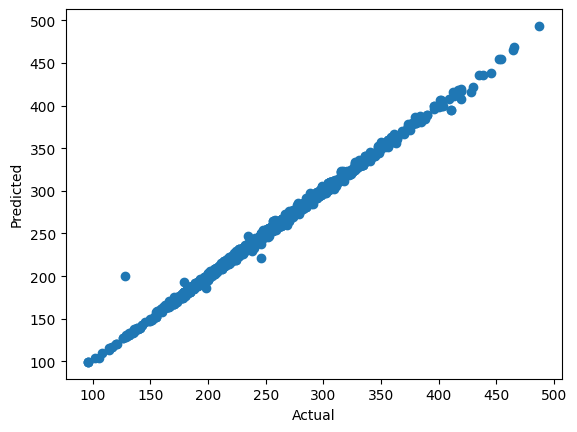

In [366]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

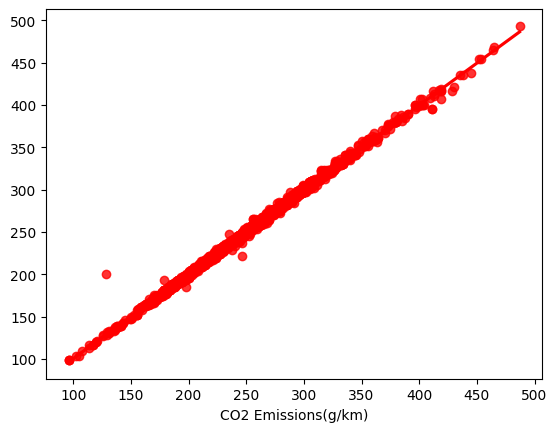

In [367]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [368]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
5340,232,231.133240,0.866760
3783,190,191.750854,-1.750854
1582,244,245.955383,-1.955383
309,258,260.003784,-2.003784
1849,262,265.014862,-3.014862
...,...,...,...
1482,267,269.624146,-2.624146
6411,193,191.983093,1.016907
3662,291,291.242706,-0.242706
6704,318,316.010620,1.989380


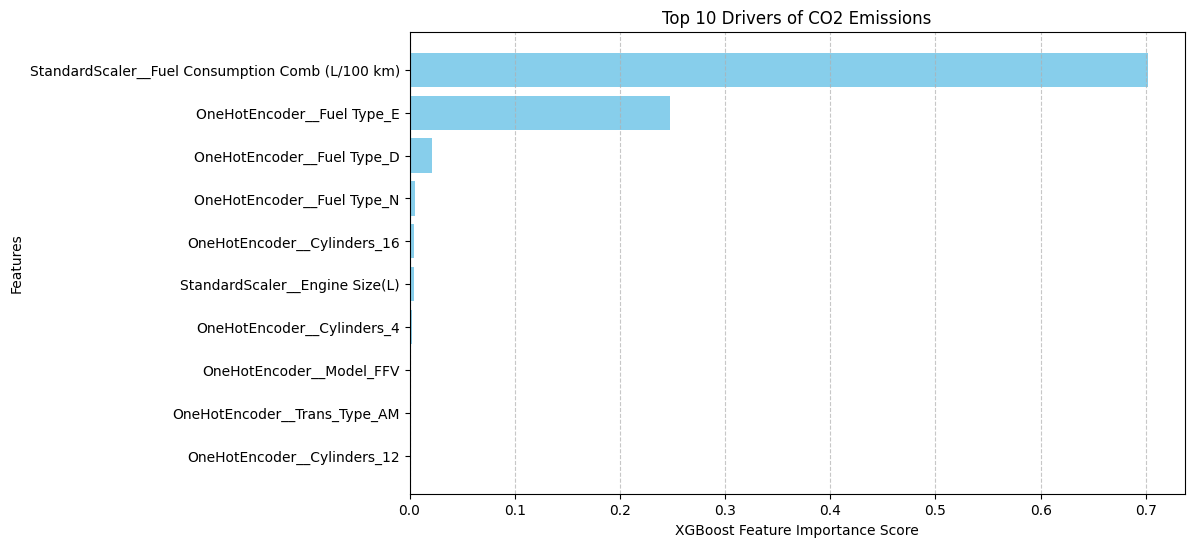

In [370]:
# Extract feature importances from the trained XGBoost model
importances = xgb_model.feature_importances_
feature_names = preprocessor.get_feature_names_out() # Get names after encoding

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True).tail(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("XGBoost Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Drivers of CO2 Emissions")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Final Conclusion and Model Insights

The feature importance analysis validates the model's logic. The **Fuel Consumption Comb** feature emerges as the dominant predictor, accounting for nearly **70%** of the model's decision-making process. 

**Key Takeaways:**
* **Physical Consistency:** The high importance of fuel consumption and fuel type (specifically Ethanol - Type E) aligns with the chemical reality of combustion, where $CO_2$ is a direct byproduct of fuel mass burned.
* **Feature Engineering Value:** Even with the dominance of fuel metrics, the inclusion of engineered features like `Trans_Type` and `Engine Size` allowed the model to achieve a near-perfect $R^2$ score of **0.9972** by refining predictions for specific vehicle architectures.
* **Model Robustness:** The model effectively ignores noise and focuses on the most impactful physical attributes, making it a reliable tool for estimating carbon footprints based on standard vehicle specifications.